In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_plt

from pprint import pprint
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("data/stock_data.csv")
df.head()

,date,close,volume,open,high,low,symbol
0,2020-07-23,122.93,11010220,127.74,129.8494,121.32,SQ
1,2020-07-22,129.18,8437494,127.49,131.7100,127.06,SQ
2,2020-07-21,126.99,10787520,129.95,130.8000,125.07,SQ
3,2020-07-20,128.39,12423990,121.26,129.4600,120.53,SQ
4,2020-07-17,120.73,6968161,120.98,122.3800,118.59,SQ


In [3]:
# Get only the valid columns
df = df [['date', 'symbol', 'close']]

# Make symbol the headers (Pivot)
df = df.pivot(
    index='date',
    columns='symbol',
    values='close'
)

df.head()

symbol,AAPL,MSFT,SQ
date,,,
2020-01-24,318.31,165.04,71.14
2020-01-27,308.95,162.28,71.05
2020-01-28,317.69,165.46,74.80
2020-01-29,324.34,168.04,76.16
2020-01-30,323.87,172.78,76.10


In [15]:
# Print Functionality
def print_func(title: str, df):
    print('')
    print('='*80)
    print(title)
    print('-'*80)
    print(df)
    print('-'*80)

In [5]:
# Calculate Log returns
log_return = np.log(1 + df.pct_change())

# Generate Random Weights (of each portfolio)
random_weights = np.array(np.random.random(3))
random_weights /= np.sum(random_weights) # Summing to 1

# Calculate Expected Return (Rp) for the whole year, i.e. 252 working days
rp = np.sum((log_return.mean() * random_weights) * 252)

# Calculate Expected Volatility, for whole year
exp_vol = np.sqrt(
    np.dot(
        random_weights.T,
        np.dot(
            log_return.cov() * 252,
            random_weights
        )
    )
)

# Calculate Sharpe Ratio
sharpe_ratio = rp / exp_vol

weights_df = pd.DataFrame(data={
    'random_weights': random_weights,
})
print_func('PORTFOLIO WEIGHTS:', weights_df)

metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': rp,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])
print_func('PORTFOLIO METRICS:', metrics_df)


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
   random_weights
0        0.460553
1        0.076843
2        0.462604
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  \
0                    0.684995                       0.656308   

   Portfolio Sharpe Ratio  
0                 1.04371  
--------------------------------------------------------------------------------


### Monte Carlo Simulation

In [6]:
num_of_portfolios = 6000 # Number of simulations
np.random.seed(42)

log_return = np.log(df / df.shift(1))
log_return = log_return.dropna()

all_weights = np.zeros((num_of_portfolios, 3)) # 5000 iter for 3 stocks
ret_arr = np.zeros(num_of_portfolios)
vol_arr = np.zeros(num_of_portfolios)
sharpe_arr = np.zeros(num_of_portfolios)

mean_returns = log_return.mean().values
cov_matrix = log_return.cov().values


for i in range(num_of_portfolios):
    if i > 0 and i <= 1000:
        # First segment: Favor portfolio 1 (higher alpha for portfolio 1)
        alpha = [1.5, 1.0, 1.0]
    elif i > 1000 and i <= 2000:
        # Second segment: Favor portfolio 2
        alpha = [1.0, 1.5, 1.0]
    elif i > 2000 and i <= 3000:
        # Third segment: Favor portfolio 3
        alpha = [1.0, 1.0, 1.5]
    elif i > 3000 and i <= 4000:
        # Fourth segment: More balanced weights
        alpha = [1.0, 1.0, 1.0]
    elif i > 4000 and i <= 5000:
        # Fifth segment: Favor portfolios 2 and 3
        alpha = [1.0, 1.5, 1.5]
    else:
        # Sixth segment: Favours portfolios 1 and 3
        alpha = [1.5, 1.0, 1.5]

    # Using Dirichlet Distribution to get the random values and storing it
    all_weights[i] = np.random.dirichlet(alpha)
    
    # Calc expected log returns
    ret_arr[i] = np.dot(all_weights[i], mean_returns) * 252
    
    # Calc Volatility
    vol_arr[i] = np.sqrt(
        np.dot(
            all_weights[i].T, 
            np.dot(
                cov_matrix * 252, 
                all_weights[i]
            )
        )
    )

    
    # Calc Sharpe Ratio
    risk_free_rate = 0.02
    sharpe_arr[i] = (ret_arr[i] - risk_free_rate) / vol_arr[i]


In [7]:
# Create new Dataframe 
simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]
simulations_df = pd.DataFrame(data=simulations_data).T

# Giving Column Names
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

simulations_df = simulations_df.infer_objects()

print_func('SIMULATIONS RESULT:', simulations_df.head())


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio  \
0  0.553353    0.592260      0.900538   
1  0.864009    0.759450      1.111342   
2  0.370486    0.542207      0.646407   
3  0.522300    0.578709      0.867966   
4  0.624243    0.624431      0.967670   

                                   Portfolio Weights  
0  [0.48028469286233844, 0.24500818932202068, 0.2...  
1  [0.29781411039443373, 0.004144013075052749, 0....  
2  [0.8570364728961569, 0.07766549322233594, 0.06...  
3  [0.4174531610963796, 0.36213046193387405, 0.22...  
4  [0.4622391128263664, 0.16296570209778222, 0.37...  
--------------------------------------------------------------------------------


### Getting important Metrics

In [8]:
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()] # Mazimum sharpe Ratio

min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()] # Minimum risk (volatility)

print_func('MAX SHARPE RATIO: ', max_sharpe_ratio)
print_func('MIN VOLATILITY: ', min_volatility)


MAX SHARPE RATIO: 
--------------------------------------------------------------------------------
Returns                                                       1.095692
Volatility                                                    0.911538
Sharpe Ratio                                                  1.180085
Portfolio Weights    [0.006615507227936485, 0.00253866672786374, 0....
Name: 3885, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY: 
--------------------------------------------------------------------------------
Returns                                                       0.336248
Volatility                                                    0.532936
Sharpe Ratio                                                  0.593408
Portfolio Weights    [0.7553253991413381, 0.24402717183927955, 0.00...
Name: 5156, dtype: object
--------------------------------------------------------------------------------


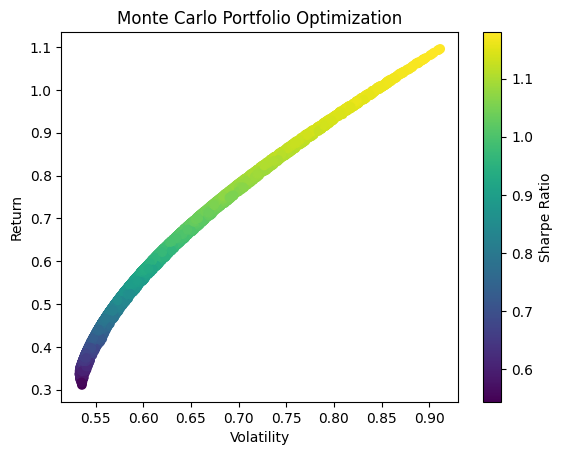

In [9]:
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Monte Carlo Portfolio Optimization')
plt.show()


### Optimization

In [24]:
import scipy.optimize as sci_opt

In [31]:
# Assume df is defined earlier with 3 columns
log_return = np.log(1 + df.pct_change()).dropna()

def get_metrics(weights):
    weights = np.array(weights)
    assert len(weights) == 3, "Weights must have 3 elements"
    
    # Returns (annualized)
    ret = np.sum(log_return.mean() * weights) * 252
    
    # Volatility (annualized)
    vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
    
    # Sharpe Ratio (assuming risk-free rate = 0)
    sr = ret / vol
    
    return np.array([ret, vol, sr])  

def grab_neg_sharpe(weights):
    metrics = get_metrics(weights)
    return metrics[2] - 1  # Extract Sharpe ratio and negate it

def grab_vol(weights):
    return get_metrics(weights)[1]

def check_sum(weights):
    return np.sum(weights) - 1

In [32]:
# Bounds and constraints
bounds = tuple((0, 1) for _ in range(3))  # 3 assets
constraints = ({'type': 'eq', 'fun': check_sum})

# Initial guess
init_guess = 3 * [1 / 3]  # Equal weights

In [33]:
# Optimize for maximum Sharpe ratio
optimized_sharpe = sci_opt.minimize(
    grab_neg_sharpe,  # Objective function to minimize (negative Sharpe)
    init_guess,       # Starting point
    method='SLSQP',
    bounds=bounds,    # Weight bounds (0 to 1)
    constraints=constraints  # Sum to 1 constraint
)

# Print results
print_func("OPTIMIZED SHARPE RATIO:", optimized_sharpe)


OPTIMIZED SHARPE RATIO:
Portfolio Weights: [1. 0. 0.] (Sum: 1.000000)
Return: 0.31
Volatility: 0.54
Sharpe Ratio: 0.58


In [34]:
optimized_metrics = get_metrics(weights=optimized_sharpe.x)
print_func("OPTIMIZED WEIGHTS:", optimized_sharpe.x)
print_func("OPTIMIZED METRICS:", optimized_metrics)


OPTIMIZED WEIGHTS:
[1.0000000e+00 4.4408921e-16 0.0000000e+00]

OPTIMIZED METRICS:
[0.31086729 0.53553897 0.58047558]


In [35]:
# Bounds and constraints
bounds = tuple((0, 1) for _ in range(3))  # 3 assets
constraints = ({'type': 'eq', 'fun': check_sum})

# Initial guess
init_guess = 3 * [1 / 3]  # Equal weights

In [36]:
# Optimize for maximum Sharpe ratio
optimized_vol = sci_opt.minimize(
    grab_vol,  # Objective function to minimize (negative Sharpe)
    init_guess,       # Starting point
    method='SLSQP',
    bounds=bounds,    # Weight bounds (0 to 1)
    constraints=constraints  # Sum to 1 constraint
)

# Print results
print_func("OPTIMIZED VOLATILITY RATIO:", optimized_sharpe)


OPTIMIZED VOLATILITY RATIO:
Portfolio Weights: [1. 0. 0.] (Sum: 1.000000)
Return: 0.31
Volatility: 0.54
Sharpe Ratio: 0.58


In [37]:
optimized_metrics = get_metrics(weights=optimized_vol.x)
print_func("OPTIMIZED WEIGHTS:", optimized_vol.x)
print_func("OPTIMIZED METRICS:", optimized_metrics)


OPTIMIZED WEIGHTS:
[7.48507672e-01 2.51492328e-01 1.95156391e-17]

OPTIMIZED METRICS:
[0.33649631 0.53286095 0.6314899 ]
